In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import pickle as pk
import os

import matplotlib.pyplot as plt
import seaborn as sns

## Strategy Comparisons

We're going to compare the effectiveness of the "best guess", "best answer", and "random answer" strategies. We can load our simulation results from `strategy_simulations.py`. To compare against our personal baseline, we'll need to bootstrap from my historical distribution since I haven't played every possible wordle game. 

In [3]:
#strategies to compare
strategy_list = ["best_guess", "best_answer", "random_answer", "personal"]

In [4]:
#my personal performance, num_turns: number of times I won in that number of turns. 

my_performance = {1:0, 2: 0, 3:3, 4:6, 5:6, 6:1, 7:1}

my_turn_dist = []
for turn, count in my_performance.items():
    my_turn_dist.extend([turn]*count)
    
my_turn_dist = np.asarray(my_turn_dist)

In [5]:
num_words = 2315 

df_list = []

for rep in range(10):
    for strategy in strategy_list:
        
        #bootstrap
        if strategy == "personal":
            num_turns = np.random.choice(my_turn_dist, num_words)
        
        #load simulation results
        else:
            fp = "results/{}_strategy_full_results_rep={}.pk".format(strategy, rep)
            full_results = pk.load(open(fp, "rb"))

            num_turns = np.asarray([int(len(x)/2) for x in full_results.values()])
        
        df = pd.DataFrame()
        df['num_turns'] = num_turns
        df['rep'] = rep
        df['strategy'] = strategy

        df_list.append(df)
        
full_df = pd.concat(df_list)

In [6]:
full_df.head()

,num_turns,rep,strategy
0,3,0,best_guess
1,3,0,best_guess
2,3,0,best_guess
3,3,0,best_guess
4,3,0,best_guess


## Visualization

Now that we're finished loading in the data, let's visualize the results!

In [7]:
#ugly hack for making sure that x-axis is the same for everybody. 

from itertools import product

reps, num_turns = np.arange(10), np.arange(1,full_df['num_turns'].max() + 1)

reps_by_turns = []
for a, b in product(reps, num_turns): reps_by_turns.append([a,b])
reps_by_turns = np.asarray(reps_by_turns)

empty_df = pd.DataFrame({'num_turns': reps_by_turns[:,1],
                         'rep': reps_by_turns[:,0]})

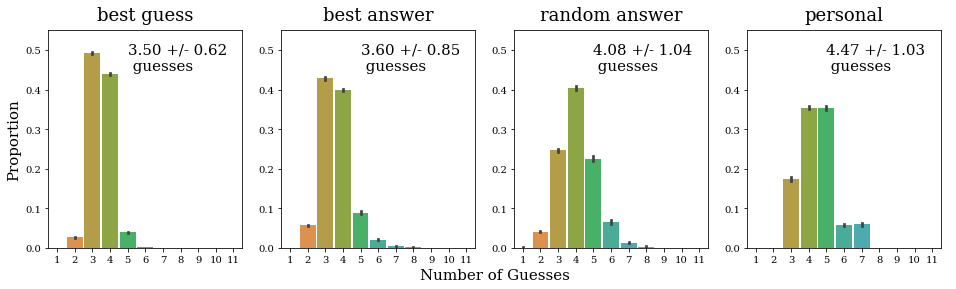

In [8]:
#plotting script

plt.rcParams["font.family"] = "serif"

pretty_strategy = {"best_guess": "best guess", 
                   "best_answer": "best answer",
                   "random_answer": "random answer",
                   "personal": "personal"}

fig, axes = plt.subplots(ncols = 4, figsize = (16,4), sharex=True)

fig.add_subplot(111, frameon=False)

for idx, (ax, strategy) in enumerate(zip(axes, strategy_list)):
    
    data = full_df[full_df['strategy'] == strategy][["num_turns", "rep"]]
    result_df = data.groupby(['num_turns', 'rep']).size().reset_index(name='count')
    result_df['count'] = result_df['count']/num_words
    
    merged_df = pd.merge(empty_df, result_df, on = ['num_turns', 'rep'], how = "left")
    merged_df = merged_df.fillna(0)
    
    mean_std = data['num_turns']
    
    mean, std = np.mean(data['num_turns'].values), np.std(data['num_turns'].values)
    
    ax.set_title("{}".format(pretty_strategy[strategy]), fontsize = 18, pad = 10)

    sns.barplot(data = merged_df, x = "num_turns", y = "count", 
                width = 0.9, dodge = False, ax = ax)
    ax.text(4, 0.45, '{:.2f} +/- {:.2f} \n guesses'.format(mean, std), size=15, color='black')
    ax.set_ylim(0.0, 0.55)
    
for idx, ax in enumerate(axes.flatten()):
    ax.set_ylabel("")
    ax.set_xlabel("")
        
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Proportion", fontsize = 15)
plt.xlabel("Number of Guesses", fontsize = 15)
    
plt.savefig("results/simulation_results.png", dpi = 300)

## Statistical Testing

The story is pretty clear from the visualization, but we can also run a statistical test. In this case, since we have the strategy results for every wordle word, we can use a paired statistical test. i.e., for any given word, I can compare the performance of each strategy (except personal) on that word. 

In [9]:
from scipy.stats import ttest_rel

In [10]:
def compare_two_strategies(strategy1, strategy2):
    
    x = full_df[full_df['strategy'] == strategy1]['num_turns'].values
    y = full_df[full_df['strategy'] == strategy2]['num_turns'].values
    
    return ttest_rel(x, y, alternative = "less")

In [11]:
compare_two_strategies("best_guess", "best_answer")

Ttest_relResult(statistic=-20.456898423901464, pvalue=1.7051179721031718e-92)

In [12]:
compare_two_strategies("best_answer", "random_answer")

Ttest_relResult(statistic=-57.47149829315941, pvalue=0.0)

In [13]:
compare_two_strategies("random_answer", "personal")

Ttest_relResult(statistic=-40.824800750295, pvalue=0.0)